In [101]:
from datasets import load_dataset, concatenate_datasets, DatasetDict

In [102]:
dataset = load_dataset("slon-hk/BooksSummarizationRU")

In [103]:
dataset

DatasetDict({
    train: Dataset({
        features: ['ID', 'Title', 'Author', 'Summary', 'Full Text'],
        num_rows: 1271
    })
    test: Dataset({
        features: ['ID', 'Title', 'Author', 'Summary', 'Full Text'],
        num_rows: 142
    })
})

In [104]:
dataset = dataset.map(lambda x: {"len": len(x["Full Text"])})

In [105]:
full_dataset = concatenate_datasets([dataset["train"], dataset["test"]])

In [106]:
import pandas as pd

df = pd.DataFrame(full_dataset)

In [107]:
df.isnull().sum()

ID           0
Title        0
Author       0
Summary      0
Full Text    0
len          0
dtype: int64

In [108]:
median_len = df['len'].median()
print(f"Median length: {median_len}")
mean_len = df['len'].mean()
print(f"Mean length: {mean_len}")
target_len = median_len
print(f"Target length: {target_len}")

Median length: 137195.0
Mean length: 313618.4975230007
Target length: 137195.0


In [109]:
MAX_BOOKS_PER_AUTHOR = 2
selected_books_ids = []
grouped = df.groupby('Author')

print("Number of authors:", len(grouped))

Number of authors: 375


In [110]:
df['len'].describe()

count    1.413000e+03
mean     3.136185e+05
std      4.192993e+05
min      7.260000e+02
25%      3.195000e+04
50%      1.371950e+05
75%      4.498830e+05
max      3.807064e+06
Name: len, dtype: float64

In [111]:
import math

CHARS_PER_PAGE = 2000
df['num_pages'] = df['len'].apply(lambda x: math.ceil(x / CHARS_PER_PAGE))
df = df[df['num_pages'] > 1]

In [112]:
for author, group in grouped:
    group['len_diff'] = abs(group['len'] - target_len)

    group_sorted = group.sort_values(by='len_diff')
    selected_author_books = group_sorted.head(MAX_BOOKS_PER_AUTHOR)
    selected_books_ids.extend(selected_author_books['ID'].tolist())

len(selected_books_ids)

658

In [113]:
df_selected = df[df['ID'].isin(selected_books_ids)].copy()

df_selected['len'].describe()

count    6.530000e+02
mean     3.483646e+05
std      3.912529e+05
min      2.621000e+03
25%      6.979300e+04
50%      1.816260e+05
75%      4.909990e+05
max      1.903540e+06
Name: len, dtype: float64

In [114]:
df_selected[['Title', 'len', 'num_pages']].head()

,Title,len,num_pages
1,Дальнейшие приключения Робинзона Крузо,316541,159
2,Сказка о жабе и розе,12609,7
3,Бобыль,38263,20
7,Делай со мной что захочешь,1247741,624
8,Инспектор пришёл,129612,65


In [115]:
import numpy as np 

TARGET_PAGES_PER_BOOK = 10
output_data = []

for index, row in df_selected.iterrows():
    book_id = row['ID']
    title = row['Title']
    author = row['Author']
    total_pages = row['num_pages']
    
    num_sample_pages = min(total_pages - 1, TARGET_PAGES_PER_BOOK)
    if num_sample_pages == 0:
         page_indices = [1]
    else:
        page_indices = np.linspace(1, total_pages - 1, num_sample_pages)
        page_indices = np.unique(np.floor(page_indices).astype(int) + 1)
        
    for page_num in page_indices:
        if page_num <= total_pages:
            output_data.append({
                'ID': book_id,
                'title': title,
                'author': author,
                'target_page': int(page_num),
                'total_pages': total_pages,
                'text_length': row['len']
            })

In [116]:
df_output = pd.DataFrame(output_data)


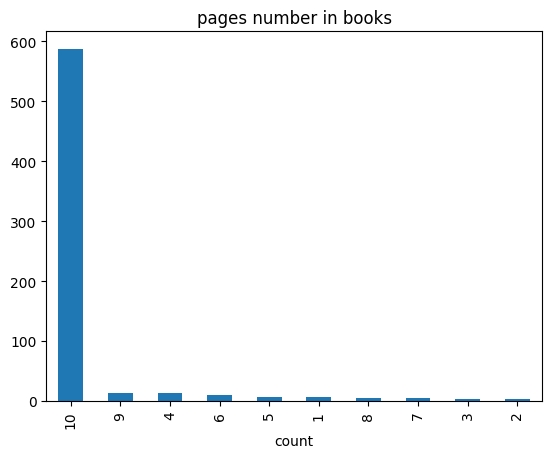

In [120]:
import matplotlib.pyplot as plt

df_output['ID'].value_counts().value_counts().plot(kind='bar')
plt.title('pages number in books')
plt.show()